In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [6]:
df['Annual Income'].fillna(df['Annual Income'].median(), inplace=True)

In [7]:
df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)

In [8]:
df['Months since last delinquent'].fillna((df['Months since last delinquent'].mean() + df['Months since last delinquent'].mode()[0]) / 2, inplace=True)

In [9]:
df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0], inplace=True)

In [10]:
df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score'] / 10

In [11]:
df['Credit Score'].fillna(df['Credit Score'].mean(), inplace=True)

In [12]:
df.loc[df['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = df.loc[df['Current Loan Amount'] < 1000000, 'Current Loan Amount'].mean()

In [13]:
df = pd.get_dummies(df)

In [14]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

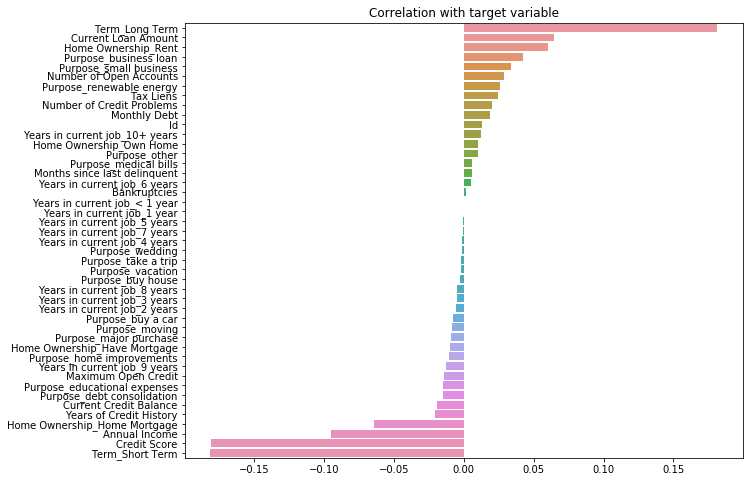

In [15]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [16]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [18]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=2,
                                      class_weights=[1, 2.4],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      4047
           1       0.44      0.72      0.54      1578

    accuracy                           0.66      5625
   macro avg       0.65      0.68      0.64      5625
weighted avg       0.74      0.66      0.68      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1340
           1       0.42      0.72      0.53       535

    accuracy                           0.63      1875
   macro avg       0.63      0.66      0.61      1875
weighted avg       0.72      0.63      0.65      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               799  541
1               150  385


In [27]:
df_test = pd.read_csv('test.csv')

In [28]:
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)
df_test['Years in current job'].fillna(df_test['Years in current job'].mode()[0], inplace=True)
df_test['Months since last delinquent'].fillna((df_test['Months since last delinquent'].mean() + df_test['Months since last delinquent'].mode()[0]) / 2, inplace=True)
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].mode()[0], inplace=True)
df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score'] = df_test['Credit Score'] / 10
df_test['Credit Score'].fillna(df_test['Credit Score'].mean(), inplace=True)
df_test.loc[df_test['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = df_test.loc[df_test['Current Loan Amount'] < 1000000, 'Current Loan Amount'].mean()

In [29]:
df_test = pd.get_dummies(df_test)

In [30]:
test_pred = final_model.predict(df_test)

In [31]:
np.savetxt("DVdovin_predictions.csv", test_pred, delimiter=",")